In [1]:
import os
import random
import warnings
from collections import defaultdict
from pathlib import Path
from tqdm.notebook import tqdm
from typing import Any, Dict, List, Optional, Union, Tuple

import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as img
import seaborn as sns
import plotly.graph_objects as go
from matplotlib.axes import Axes
from scipy.stats import mode, skew, kurtosis
from seaborn import JointGrid

# Configuration
warnings.simplefilter('ignore')
sns.set_style("darkgrid")
colors = sns.color_palette('Set2')
random.seed(42)

In [2]:
def _plot_univar_dist(
    data: Union[pd.Series, np.ndarray], feature: str, bins: int = 250, ax: Optional[Axes] = None
) -> None:
    """Plot univariate distribution.

    Parameters:
        data: univariate data to plot
        feature: feature name of the data
        bins: number of bins
        ax: user-specified axes

    Return:
        None
    """
    if isinstance(data, np.ndarray):
        data = pd.Series(data)

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 4))
    sns.histplot(data=data, bins=bins, kde=True, palette=colors, ax=ax)
    ax.axvline(x=data.mean(), color="orange", linestyle="dotted", linewidth=1.5, label="Mean")
    ax.axvline(
        x=data.median(),
        color="green",
        linestyle="dotted",
        linewidth=1.5,
        label="Median",
    )
    # ax.axvline(
    #     x=data.mode().values[0],
    #     color="red",
    #     linestyle="dotted",
    #     linewidth=1.5,
    #     label="Mode",
    # )
    ax.set_title(
        f"{feature.upper()} Distibution\n"
        f"Min {round(data.min(), 2)} | "
        f"Max {round(data.max(), 2)} | "
        # f"Skewness {round(data.skew(), 2)} | "
        # f"Kurtosis {round(data.kurtosis(), 2)}"
    )
    ax.set_xlabel(f"{feature}")
    ax.set_ylabel("Bin Count")
    ax.legend()
    if ax is None:
        plt.show()
        

def _plot_bivar(
    data: Union[pd.Series, np.ndarray],
    features: Optional[List[str]] = ["0", "1"],
) -> Tuple[JointGrid, str]:
    """Plot bivariate distribution with regression line fitted.

    Parameters:
        data: bivariate data to plot
        features: list of feature names

    Return:
        jg: seaborn JointGrid
        title: figure title
    """
    if isinstance(data, np.ndarray):
        data = pd.DataFrame(data)
    f1, f2 = features[0], features[1]
    corr = data[[f1, f2]].corr().iloc[0, 1]

    title = f"{f1} versus {f2}, Corr={corr:.2}"
    jg = sns.jointplot(
        x=data[f1],
        y=data[f2],
        kind="reg",
        height=6,
        marginal_ticks=True,
        joint_kws={"line_kws": {"color": "orange"}},
    )
    jg.ax_joint.set_xlabel(f1)
    jg.ax_joint.set_ylabel(f2)
    
    return jg, title

In [3]:
DATA_ROOT = "/nfs/home/ryan0507/google_gnn/npz_all/npz"

In [4]:
layout_sample = dict(np.load(f"{DATA_ROOT}/layout/nlp/default/train/albert_en_base_batch_size_32_test.npz"))
for k, v in layout_sample.items():
    print(f"{k:<16}", f"| Dtype: {str(v.dtype):<8} | Shape {v.shape}")

edge_index       | Dtype: int64    | Shape (2697, 2)
node_feat        | Dtype: float32  | Shape (1696, 140)
node_opcode      | Dtype: uint8    | Shape (1696,)
node_config_feat | Dtype: float32  | Shape (100040, 121, 18)
node_config_ids  | Dtype: int64    | Shape (121,)
node_splits      | Dtype: int64    | Shape (1, 2)
config_runtime   | Dtype: int64    | Shape (100040,)


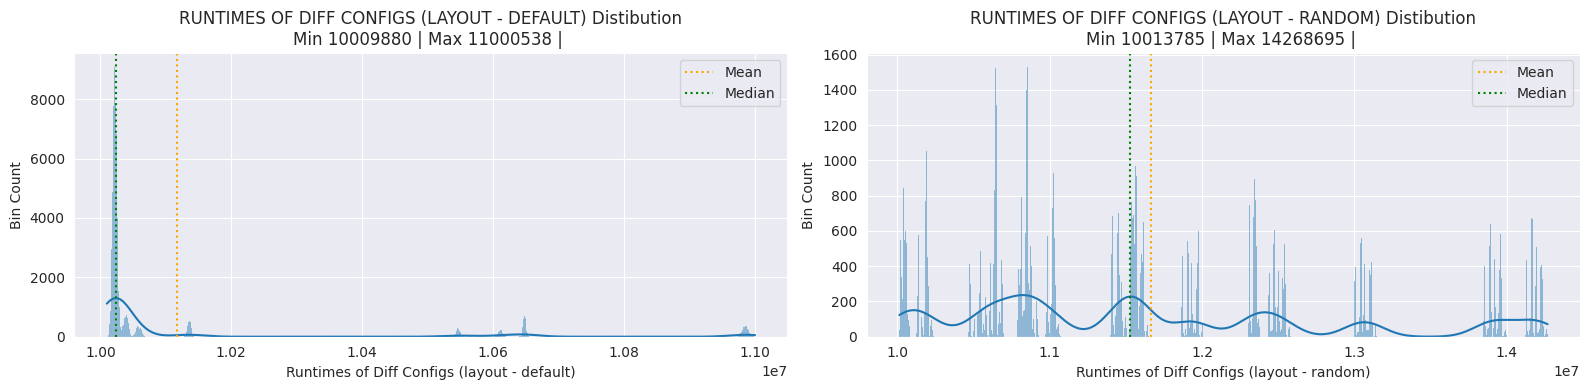

In [5]:
layout_sample2 = dict(np.load(f"{DATA_ROOT}/layout/nlp/random/train/albert_en_base_batch_size_32_test.npz"))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
_plot_univar_dist(layout_sample["config_runtime"], "Runtimes of Diff Configs (layout - default)", 1000, ax=axes[0])
_plot_univar_dist(layout_sample2["config_runtime"], "Runtimes of Diff Configs (layout - random)", 1000, ax=axes[1])
plt.tight_layout()

In [8]:
# Metadata
# ==Data==
# Compiler optimization
OPTIM = ["layout", "tile"]
# Source
SRC = ["xla", "nlp"]
# Search strategy
SEARCH = ["default", "random"]
# Dataset split
SPLIT = ["train", "valid", "test"]
# Collection
COLL = [
    "layout-nlp-default",
    "layout-nlp-random",
    "layout-xla-default",
    "layout-xla-random",
    "tile-xla"
]

def _get_coll_root(coll: str) -> Path:
    """Parse the collection and return the corresponding data root.
    
    Parameters:
        coll: collection

    Return
        data_root: data root of the collection
    """
    coll_terms = coll.split("-")
    if len(coll_terms) == 3:
        optim, src, search = coll_terms
        data_root = f"{DATA_ROOT}/{optim}/{src}/{search}"
    else:
        optim, src = coll_terms
        data_root = f"{DATA_ROOT}/{optim}/{src}"

    return data_root

class GraphStatsEngineer(object):
    """Derive basic statistics of graphs from different collections.

    Parameters:
        coll: collection
            *Note: Run all collections if not given
        debug: if False, sanity checks are ignored
    """

    def __init__(self, coll: Optional[str] = None, debug: bool = False) -> None:
        self.coll = [coll] if coll is not None else COLL
        self.debug = debug

    def run(self, stats_list: List[str] = ["n_nodes"]) -> Tuple[Dict[str, Any], List[str]]:
        """Derive the graph stats.
        
        Parameters:
            stats_list: graph stats, the choices are as follows:
                {"n_nodes", "n_edges", "avg_deg", "avg_clust_coeff", "longest_path"}

        Return:
            stats: graph statistics
            npz_illeg: .npz files failing sanity checks
        """
        stats = {}
        npz_illeg = []
        
        for coll in self.coll:
            stats[coll] = {"split": [], "file": [], "n_graphs": 0}
            for s in stats_list:
                stats[coll][s] = []
            coll_root = _get_coll_root(coll)
            
            for split in SPLIT:
                data_root = f"{coll_root}/{split}"
                for file in tqdm(os.listdir(data_root)):
                    if file.endswith(".npz"):
                        stats[coll]["split"].append(split)
                        stats[coll]["file"].append(file)
                        stats[coll]["n_graphs"] += 1
                    else:
                        continue
                    
                    # Prepare data
                    npz_tmp = self._load_npz(f"{data_root}/{file}")
                    g_tmp = self._get_digraph(npz_tmp["edge_index"])
    
                    # Derive stats
                    stats_tmp = self._run_single(npz_tmp, g_tmp, stats_list)
                    if stats_tmp is not None:
                        for s, v in stats_tmp.items():
                            stats[coll][s].append(v)
                    else:
                        npz_illeg.append(str(data_root/file))
                        
        return stats, npz_illeg

    def _load_npz(self, data_file: Path) -> Dict[str, np.ndarray]:
        """Load and return the graph with its configurations.

        Parameters:
            data_file: path to data

        Return:
            npz_tmp: graph and configurations
        """
        npz_tmp = dict(np.load(data_file))

        return npz_tmp
    
    def _get_digraph(self, edge_index: np.ndarray) -> nx.DiGraph:
        """Return the NetworkX Graph.

        Parameters:
            edge_index: edge index

        Return:
            digraph: directed graph representation of the computational
                graph
        """
        edge_list = list(map(tuple, edge_index))
        digraph = nx.DiGraph(edge_list)

        return digraph
    
    def _run_single(
        self,
        npz: Dict[str, np.ndarray],
        g: nx.DiGraph,
        stats_list: List[str]
    ) -> Optional[Dict[str, float]]:
        """Derive the graph stats for a single graph.
        
        Parameters:
            npz: graph and configurations
            g: directed graph representation of the computational graph
            stats: graph stats

        Return:
            stats_single: graph stats of the current graph
        """
        stats_single = {}
        if "n_nodes" in stats_list:
            n_nodes = g.order()
            if self.debug and n_nodes != len(npz["node_feat"]):
                return None
            stats_single["n_nodes"] = n_nodes
        if "n_edges" in stats_list:
            n_edges = g.size()
            if self.debug and n_edges != len(npz["edge_index"]):
                return None
            stats_single["n_edges"] = n_edges
        if "avg_deg" in stats_list:
            n_nodes = g.order()  # Note if any orphan node
            avg_deg = sum(dict(g.degree).values()) / n_nodes
            avg_indeg = sum(dict(g.in_degree).values()) / n_nodes
            avg_outdeg = sum(dict(g.out_degree).values()) / n_nodes
            if self.debug and avg_deg != avg_indeg + avg_outdeg:
                return None
            stats_single["avg_deg"] = avg_deg
        if "avg_clust_coeff" in stats_list:
            avg_clust_coeff = nx.average_clustering(g)
            stats_single["avg_clust_coeff"] = avg_clust_coeff
        if "longest_path" in stats_list:
            longest_path = nx.dag_longest_path_length(g)
            stats_single["longest_path"] = longest_path

        return stats_single

In [9]:
eng = GraphStatsEngineer(debug=False)
stats_list = ["n_nodes", "n_edges", "avg_deg", "avg_clust_coeff", "longest_path"]
stats, _ = eng.run(stats_list)

  0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/207 [00:00<?, ?it/s]